Fitting and Gaussian and Polya combined model to the integral histograms to extract the peak and calculate the gain. 

Polya fits to the signal peak while Gaussian fits to the noise peak. Polya peak position used in gain calculation.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gamma
import os
import glob
import re


spe_files = glob.glob('141125_darkrate_2000_10000_2_off_processed_threshold15_cleaned.csv')
#darkrate_files = glob.glob('DarkRateData/*.csv')

still not fitting properly:

2000 1,2,3 off

1950 1,3 on 

1950 2,3 off

only both fits in one for over 2000 and 1950 V if not just remove the first 2 bins in the fit



want to return a csv with columns:

voltage | polya peak | polya peak error | gaussian peak | gaussian peak error

only those with voltage of 1950 or 2000 will have anything in the gaussian peak columns

for those with voltages 1750 to 1900, the first two bins will be removed for the polya fit. 

In [26]:
#get the voltage

def get_voltage(filepath):
    filename = os.path.basename(filepath)
    match = re.search(r'_(\d{3,4})_', filename)
    return int(match.group(1))

In [27]:
def polya_dist(positive_charge_data, A, nbar, theta):
    # A = amplitide/normalisation factor
    polya_PMF = A*((theta + 1)**(theta + 1))*(1/gamma(theta + 1))*((positive_charge_data/nbar)**theta)*np.exp(-(theta + 1)*(positive_charge_data/nbar))
    return polya_PMF


def combined_model(x, A_p, nbar, theta, A_g, mu, sigma):
    # Constraint handling for Polya parameters
    if nbar <= 0 or theta <= -1:
        return np.ones_like(x) * 1e10
    
    #Polya Component (signal)
    polya = polya_dist(x, A_p, nbar, theta)
    
    #Gaussian Component (noise)
    gauss = A_g * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma)**2)
    
    #Gaussian peak must be to the left of Polya peak
    polya_peak_x = nbar * (theta / (theta + 1))
    if mu >= polya_peak_x:
        return np.ones_like(x) * 1e10
        
    return polya + gauss

In [28]:
#if voltage =< 1900, use just polya model to find the peak, ignoring the first two bins of the histogram when fitting

def fit_polya_and_get_peak(all_integrals_picocharge, Delta_x=0.1, bin_cut=0.2, filename=None):

    positive_charge_data = all_integrals_picocharge[all_integrals_picocharge > 0]
    int_number_of_bins = int((np.max(positive_charge_data) - np.min(positive_charge_data)) / Delta_x) #each bin is 0.1pC
    n, bins = np.histogram(positive_charge_data, bins=int_number_of_bins)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    mask = bin_centers >= bin_cut
    n_fit = n[mask]
    bin_centers_fit = bin_centers[mask]

    # Only data above bin_cut for initial guesses
    positive_charge_data_cut = positive_charge_data[positive_charge_data >= bin_cut]

    initial_nbar = np.mean(positive_charge_data_cut)
    initial_var = np.var(positive_charge_data_cut) 

    N_events = len(positive_charge_data)
    
    initial_A = N_events * Delta_x
    initial_theta = np.abs((initial_nbar**2 / initial_var) - 1)

    p0 = [initial_A, initial_nbar, initial_theta]

    popt, pcov = curve_fit(polya_dist, bin_centers_fit, n_fit , p0=p0, bounds = ([0,0,0],[np.inf,np.inf,np.inf]), maxfev=10000)
    A_fit, nbar_fit, theta_fit = popt
    err_A = np.sqrt(pcov[0, 0])
    err_nbar = np.sqrt(pcov[1, 1])
    err_theta = np.sqrt(pcov[2, 2])
    polya_dist_fit = polya_dist(bin_centers, *popt)

    peak = (theta_fit / (theta_fit + 1)) * nbar_fit
    #peak error including covariance of parameters
    dpeak_dnbar = theta_fit / (theta_fit + 1)
    dpeak_dtheta = nbar_fit / (theta_fit + 1)**2
    peak_err = np.sqrt((dpeak_dnbar * err_nbar)**2 + (dpeak_dtheta * err_theta)**2 + 2*dpeak_dnbar*dpeak_dtheta*pcov[1,2])

    # chi^2
    model_fit = polya_dist(bin_centers_fit, *popt)
    valid = n_fit > 0
    chi2 = np.sum((n_fit[valid] - model_fit[valid])**2 / n_fit[valid])
    ndof = np.sum(valid) - len(popt)
    chi2_red = chi2 / ndof

    if peak_err == np.inf:
        peak_err=-100

    plt.figure(figsize=(6,6))
    plt.bar(bin_centers_fit, n_fit, width=Delta_x, alpha=0.6, label='Data')
    x_fit = np.linspace(bin_cut, 20, 500)
    plt.plot(x_fit, polya_dist(x_fit, *popt), 'r-', lw=2, label=rf'Combined fit, $\chi^2_\nu={chi2_red:.2f}$')
    plt.axvline(peak, color='k', linestyle='--', label=rf'Polya Peak $= {peak:.3f}\pm{peak_err:.3f}$ pC')
    plt.xlim(0, 20)
    plt.xlabel('Charge (pC)')
    plt.ylabel('Counts')
    if filename is not None:
        plt.title(os.path.basename(filename)) 
    else:
        plt.title('Polya fit to pulse integral histogram')
    plt.legend()
    plt.show()

    return peak, peak_err

In [29]:
#if voltage > 1900, will have two distinct peaks (first gaussina, second polya), use combined model to find polya and gaussian peaks. plot these fitted onto the histograms

def fit_combined_and_get_peaks(all_integrals_picocharge, Delta_x=0.1, filename=None):

    positive_charge_data = all_integrals_picocharge[all_integrals_picocharge > 0]

    int_number_of_bins = int((np.max(positive_charge_data) - np.min(positive_charge_data)) / Delta_x)
    n, bins = np.histogram(positive_charge_data, bins=int_number_of_bins)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    nbar0 = np.mean(positive_charge_data)
    var0 = np.var(positive_charge_data)
    theta0 = abs(nbar0**2 / var0 - 1)
    A_p0 = len(positive_charge_data) * Delta_x
    A_g0 = np.max(n)
    mu0 = bin_centers[np.argmax(n[:5])]
    sigma0 = 0.7
    p0 = [A_p0, nbar0, theta0, A_g0, mu0, sigma0]

    popt, pcov = curve_fit(combined_model, bin_centers, n, p0=p0, absolute_sigma=False, bounds = ([0,0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf,np.inf]),maxfev=20000)
    perr = np.sqrt(np.diag(pcov))

    _, nbar_fit, theta_fit, _, mu_fit, sigma_fit = popt
    _, err_nbar, err_theta, _, err_mu, err_sigma = perr

    polya_peak = nbar_fit * theta_fit / (theta_fit + 1)

    #peak error including covariance of parameters
    dpeak_dnbar = theta_fit / (theta_fit + 1)
    dpeak_dtheta = nbar_fit / (theta_fit + 1)**2
    polya_err = np.sqrt((theta_fit/(theta_fit+1)*err_nbar)**2 + (nbar_fit/(theta_fit+1)**2 * err_theta)**2 + 2*dpeak_dnbar*dpeak_dtheta*pcov[1,2])

    gaussian_peak = mu_fit
    gaussian_err = err_mu

    # chi^2
    model_fit = combined_model(bin_centers, *popt)
    valid = n > 0
    chi2 = np.sum((n[valid] - model_fit[valid])**2 / n[valid])
    ndof = np.sum(valid) - len(popt)
    chi2_red = chi2 / ndof

    #if peak_err == np.inf:
        #peak_err=-100

    plt.figure(figsize=(6,6))
    plt.bar(bin_centers, n, width=Delta_x, alpha=0.6, label='Data')
    x_fit = np.linspace(0, max(positive_charge_data)*1.1, 500)
    plt.plot(x_fit, combined_model(x_fit, *popt), 'r-', lw=2, label=rf'Combined fit, $\chi^2_\nu={chi2_red:.2f}$')
    plt.axvline(polya_peak, color='k', linestyle='--', label=rf'Polya Peak $= {polya_peak:.3f}\pm{polya_err:.3f}$ pC')
    plt.axvline(gaussian_peak, color='b', linestyle=':', label=rf'Gaussian peak $= {gaussian_peak:.3f}\pm{gaussian_err:.3f}$ pC')
    plt.xlim(0, 20)
    plt.xlabel('Charge (pC)')
    plt.ylabel('Counts')
    if filename: plt.title(os.path.basename(filename))
    else: plt.title('Combined Polya + Gaussian fit')
    plt.legend()
    plt.show()

    return polya_peak, polya_err, gaussian_peak, gaussian_err



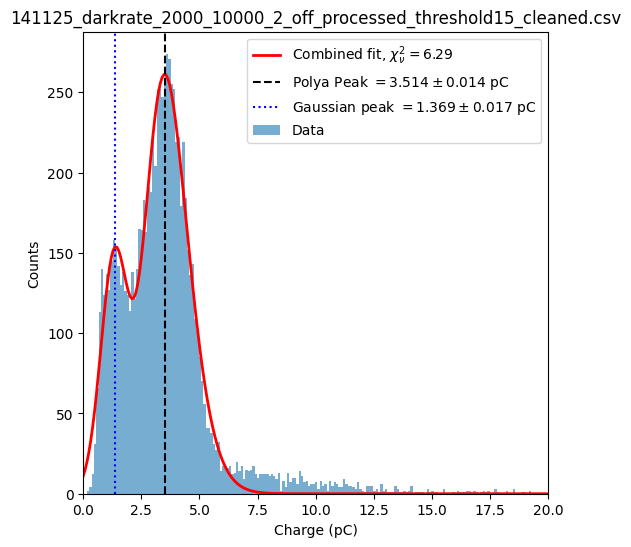

"\ndarkrate_results = []\n\nfor file in darkrate_files:\n    voltage = get_voltage(file)\n    df = pd.read_csv(file)\n    charge = df['integral_pC'].values\n\n    if voltage in [1950,2000]:\n        polya_peak, polya_err, gauss_peak, gauss_err = fit_combined_and_get_peaks(charge, filename=file)\n    else:\n        polya_peak, polya_err = fit_polya_and_get_peak(charge, bin_cut=0.2, filename=file)\n        gauss_peak, gauss_err = np.nan, np.nan\n\n    darkrate_results.append({\n        'voltage': voltage,\n        'polya_peak_pC': polya_peak,\n        'polya_peak_error_pC': polya_err,\n        'gaussian_peak_pC': gauss_peak,\n        'gaussian_peak_error_pC': gauss_err\n    })\n\ndark_df = pd.DataFrame(darkrate_results)\ndark_df.sort_values('voltage', inplace=True)\ndark_df.to_csv('darkrate_combined_peak_positions.csv', index=False)\n"

In [30]:
#loop over files with the relevant functions
spe_results = []

for file in spe_files:
    voltage = get_voltage(file)
    df = pd.read_csv(file)
    charge = df['integral_pC'].values

    if voltage in [1950,2000]:
        polya_peak, polya_err, gauss_peak, gauss_err = fit_combined_and_get_peaks(charge, filename=file)
    else:
        polya_peak, polya_err = fit_polya_and_get_peak(charge, bin_cut=0.2, filename=file)
        gauss_peak, gauss_err = np.nan, np.nan

    spe_results.append({
        'voltage': voltage,
        'polya_peak_pC': polya_peak,
        'polya_peak_error_pC': polya_err,
        'gaussian_peak_pC': gauss_peak,
        'gaussian_peak_error_pC': gauss_err})
    
spe_df = pd.DataFrame(spe_results)
spe_df.sort_values('voltage', inplace=True)
#spe_df.to_csv('spe_combined_peak_positions.csv', index=False)

'''
darkrate_results = []

for file in darkrate_files:
    voltage = get_voltage(file)
    df = pd.read_csv(file)
    charge = df['integral_pC'].values

    if voltage in [1950,2000]:
        polya_peak, polya_err, gauss_peak, gauss_err = fit_combined_and_get_peaks(charge, filename=file)
    else:
        polya_peak, polya_err = fit_polya_and_get_peak(charge, bin_cut=0.2, filename=file)
        gauss_peak, gauss_err = np.nan, np.nan
    
    darkrate_results.append({
        'voltage': voltage,
        'polya_peak_pC': polya_peak,
        'polya_peak_error_pC': polya_err,
        'gaussian_peak_pC': gauss_peak,
        'gaussian_peak_error_pC': gauss_err
    })

dark_df = pd.DataFrame(darkrate_results)
dark_df.sort_values('voltage', inplace=True)
dark_df.to_csv('darkrate_combined_peak_positions.csv', index=False)
'''
